# Visualização e Bancos de Dados com Python - Gráfico de Rede

Olá, cientistas de dados em formação!!!

Neste notebook, vamos destacar algumas funcionalidades interessantes das bibliotecas Pandas e MatPlotLib, além de adicionar mais uma biblioteca de plotagem de gráficos no nosso arsenal: a NetworkX.

## Este notebook foi criado para...

realizar uma análise exploratória em um dataset com resultados de uma pesquisa sobre turismo na Florida. Mais especificamente, vamos analisar as perguntas que demonstram como os respondentes se relacionam uns com os outros. Ou seja, vamos analisar como os respondentes se conectam uns aos outros, como em uma rede social. Para representar esses dados, iremos utilizar uma visualização de **graph network**.

### Dicionário de Dados

| **Coluna** | **Tipo de Dado** | **Descrição** |
|---|---|---|
| name | string | Nome do respondente |
|  organization | string | Organização para a qual trabalha |
|  role | string |  |
|  email | string | Email do respondente |
|  phone | string |  |
|  zipcode | string |  |
|  website | string | Website da Organização |
|  orgtype | string |  |
|  size | string |  |
|  demand_growth | string |  |
|  potential_leading | string |  |
|  preparedness | string |  |
|  activitytype | string |  |
|  thoughts_strong_industry | string |  |
|  importance_development | string |  |
|  interested_joining | string |  |
|  current_collaboration | string | Com quem o respondente usualmente colabora |
|  who_is_missing_colab | string | Quem não está na lista que o respondente també colabora |
|  current_expert | string | Quem são os experts que o respondente procura |
|  who_is_missing_expert | string | Quem são os experts que não estão na lista |
|  who_is_missing | string | Quem mais está faltando na lista |
|  id | número |  |
|  created_at | date time |  |

Para o fim de nossa análise, consideramos apenas os seguintes campos:

| **Coluna** | **Tipo de Dado** | **Descrição** |
|---|---|---|
| name | string | Nome do respondente |
|  email | string | Email do respondente |
|  organization | string | Organização do respondente |
|  current_collaboration | string | Com quem o respondente usualmente colabora |
|  who_is_missing_colab | string | Quem não está na lista que o respondente també colabora |
|  current_expert | string | Quem são os experts que o respondente procura |
|  who_is_missing_expert | string | Quem são os experts que não estão na lista |
|  who_is_missing | string | Quem mais está faltando na lista |


## Iniciando

Em primeiro lugar, vamos realizar os imports da bibliotecas que vamos usar. No final do notebook você encontrará o link para suas documentações.

In [ ]:
import re

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx


## Funções auxiliares

Criamos duas funções para nos ajudar a processar alguns campos dos nossos dados. Vamos aprender um pouco sobre as duas.

### **breakit()**

 A função **breakit** utiliza a biblioteca **re** para aplicar uma expressão regular para extrair de uma string qualquer três elementos: nome, email e empresa. Quando a função encontra, retorna no formato de uma string `nome#email#empresa`. Caso contrário, retorna a própria string enviada. Na verdade, são duas possíveis expressões regulares: uma que espera a string no formato `nome (email) - empresa` e outra para quando a string vem no formato `nome email`. Se você quiser aprender um pouco sobre expressões regulares e a biblioteca **re**, [clique aqui](https://colab.research.google.com/drive/1snTabQnhsPyHQU95wCJxziyo8akH4ZYN#scrollTo=81_7NVrYVYU4).

In [ ]:
def breakit(content):
  regex = r"^(.+)\((.+)\)\s*\-*\s*(.*)$"
  regex2 = r"^([\w+\s+]+)(\s\w+\.*\w*\@.+)$"
  matches = None
  
  if "(" in content:
    matches = re.finditer(regex, content, re.MULTILINE)
  else:
    matches = re.finditer(regex2, content, re.MULTILINE)
  
  for match in matches:
      result = []
      for item in match.groups():
        if item:
          result.append(item)
      return '#'.join(result)
  return content

### **email_format()**

A função **email_format** é bem simples: ela espera uma string no formato `nome, empresa, email` e retorna no formato `nome (email) - empresa`. O motivo é para padronizar os campos que contém a informação de pessoas que são referência para os respondentes.

In [ ]:
def email_format(content):
  if ',' in content:
    parts = content.split(',')
    return f"{parts[0]} ({parts[2]}) - {parts[1]}"
  return content

## Carregando os dados

A biblioteca Pandas tem muitas funções bem convenientes para carregar quase qualquer tipo de arquivo, e aqui iremos explorar a função read_json(). Esta função permite que você carregue uma estrutura json como um DataFrame Pandas. Mas o mais incrível é que pode ser um arquivo, ou, como iremos utilizar aqui, para ler a informação direta de uma URL.

In [ ]:
# Loading the initial data

df = pd.read_json('https://future-iq.herokuapp.com/records')

Esta função possui diversos parâmetros, que eu aconselho vocês a lerem no manual. Mas em sua utilização mais simples, ela recebe uma URL ou caminho para um arquivo JSON, ou ainda uma string contendo JSON. O formato padrão para este JSON deve ser um array de dicionários:

```json
[
  {"col1": "value",
   "col2": "value"
  },
  {"col1": "value",
   "col2": "value"
  },
  ...
  {"col1": "value",
   "col2": "value"
  }
]
```



## Processando os dados

O processamento dos dados consiste em pegar os cinco campos que contém listas de pessoas, quebra-los em varias linhas e armazenar o em novos campos separados para nome, email e organização.

O objetivo é transformar aquela entrada de dados especificado em nosso dicionário de dados, de forma que gere o seguinte output:

| **Coluna** | **Tipo de Dado** | **Descrição** |
|---|---|---|
| name | string | Nome do respondente |
|  email | string | Email do respondente |
| organization | string | Organização do respondente |
| type | string | Tipo de Conexão:  Collaboration, Expert ou Missing |
| target_name | string | Nome do indicado |
| target_email | string | Email do indicado |
| target_organization | string | Organização do indicado |

### Exemplo

O registro de entrada:

| **Coluna** | **Tipo de Dado** | **Valor** |
|---|---|---|
| name | string | Walter P. Cortes |
|  email | string | wpcortes@gmail.com |
|  organization | string | Dell |
|  current_collaboration | string | Fabio Milani (fabio.milani@dell.com) - Dell, Vera Hecht (vera.hecht@dell.com) - Dell |
|  who_is_missing_colab | string |  |
|  current_expert | string | Fabio Milani (fabio.milani@dell.com) - Dell, Ana Trindade (ana.trindade@dell.com) - Dell |
|  who_is_missing_expert | string |  |
|  who_is_missing | string |  |

Deve gerar os seguintes registros de saída:

| **name** | **email** | **organization** | **type** |**target_name** |**target_email** |**target_organization** |
|---|---|---|---|---|---|---|
| Walter P. Cortes| wpcortes@gmail.com | Dell | Collaboration | Fabio Milani | fabio.milani@dell.com | Dell |
| Walter P. Cortes| wpcortes@gmail.com | Dell | Collaboration | Vera Hecht | vera.hecht@dell.com | Dell |
| Walter P. Cortes| wpcortes@gmail.com | Dell | Expert | Fabio Milani | fabio.milani@dell.com | Dell |
| Walter P. Cortes| wpcortes@gmail.com | Dell | Collaboration | Ana Trindade| ana.trindade@dell.com | Dell |

### Primeira Etapa - Gerando um DataFrame para cada campo de target

#### Processando o campo current_collaboration

In [ ]:
# Selecionamos apenas as colunas que nos interessam
raw_collab_df = df[["name", "email", "organization", "current_collaboration"]]

# Removemos linhas com dados vazios
clean_collab_df = raw_collab_df.dropna()

# Como esta coluna parece ser uma lista, fazemos a explosão em linhas
collab_df = clean_collab_df.explode('current_collaboration')

# Renomeamos a coluna
collab_df = collab_df.rename(columns={"current_collaboration": "target"})

# Adicionamos a nova coluna que caracteriza o tipo e preenchemos com o valor adequado
collab_df["type"] = ["Collaboration" for i in range(collab_df["target"].size)]

#### Processando o campo who_is_missing_colab

In [ ]:
# Selecionamos apenas as colunas que nos interessam
missing_colab = df[["name", "email", "organization", "who_is_missing_colab"]]

# Removemos linhas com dados vazios
missing_colab = missing_colab.dropna()

# Eliminamos algumas linhas específicas
missing_colab = missing_colab.drop(axis=1, index=[3,7,40,52])

# Renomeamos a coluna
missing_colab_df = missing_colab.rename(columns={"who_is_missing_colab": "target"})

# Adicionamos a nova coluna que caracteriza o tipo e preenchemos com o valor adequado
missing_colab_df["type"] = ["Collaboration" for i in range(missing_colab_df["target"].size)]

# Aplicamos alguns ajustes na coluna target para ficar mais fácil
# o tratamento dos dados
target_series = missing_colab_df['target'].str.replace("\r\n", ",")
missing_colab_df['target'] = target_series

target_series2 = missing_colab_df['target'].str.replace('\) ', '),')
missing_colab_df['target'] = target_series2

target_series = missing_colab_df['target'].str.split(",")
missing_colab_df['target'] = target_series

# Explodimos a coluna target em linhas
missing_colab_df = missing_colab_df.explode('target')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: The default value of regex will change from True to False in a future version.


#### Processando o campo current_expert

In [ ]:
# Selecionamos apenas as colunas que nos interessam
raw_expert_df = df[["name", "email", "organization", "current_expert"]]

# Eliminamos linhas com informação incompleta
clean_expert_df = raw_expert_df.dropna()

# Explodimos em linhas
expert_df = clean_expert_df.explode('current_expert')

# Renomeamos a coluna
expert_df = expert_df.rename(columns={"current_expert": "target"})

# Adicionamos a nova coluna
expert_df["type"] = ["Expert" for i in range(expert_df["target"].size)]

#### Processando o campo who_is_missing_expert

In [ ]:
# Selecionamos apenas as colunas que nos interessam
missing_expert = df[["name", "email", "organization", "who_is_missing_expert"]]

# Removemos as linhas com colunas vazias
missing_expert = missing_expert.dropna()

# Eliminando linhas específicas
missing_expert = missing_expert.drop(axis=1, index=[3,19,40])

# Renomeando a coluna
missing_expert_df = missing_expert.rename(columns={"who_is_missing_expert": "target"})

# Adicionando a nova coluna de tipo
missing_expert_df["type"] = ["Expert" for i in range(missing_expert_df["target"].size)]

# Aplicamos alguns ajustes na coluna target para ficar mais fácil
# o tratamento dos dados
target_series = missing_expert_df['target'].str.split(";")
missing_expert_df['target'] = target_series

# Explodindo a coluna target em linhas
missing_expert_df = missing_expert_df.explode('target')

# Aplicando a função de formatação do campo de email
target_series = missing_expert_df['target'].apply(email_format)
missing_expert_df['target'] = target_series

#### Processando o campo who_is_missing

In [ ]:
# Selecionamos apenas as colunas que nos interessam
who_is_missing = df[["name", "email", "organization", "who_is_missing"]]

# Eliminamos linhas com campos vazios
who_is_missing = who_is_missing.dropna()

# Eliminamos algumas linhas específicas
who_is_missing = who_is_missing.loc[[9, 48]]

# Renomeamos a coluna
who_is_missing = who_is_missing.rename(columns={"who_is_missing": "target"})

# Adicionamos a coluna de tipo
who_is_missing["type"] = ["Missing" for i in range(who_is_missing["target"].size)]

# Aplicamos a função de formatação do email 
target_series = who_is_missing['target'].apply(email_format)
who_is_missing['target'] = target_series

### Segunda Etapa - Gerando a nossa lista integrada

Neste estágio do nosso algoritmo, temos 5 DataFrames, cada um deles contendo parte dos nossos dados. Precisamos criar um único DataFrame com todos eles juntos. Para isso, entra em cena a função **pd.concat()**, que recebe uma lista de DataFrames e retorna um único DataFrame que é a junção de todos. Como todos são iguais, se ajustam perfeitamente.

In [ ]:
# Concatenação dos dataframes
final_df = pd.concat([collab_df, expert_df, missing_colab_df, missing_expert_df, who_is_missing])

### Terceira Etapa - Aplicando Tranformações

Neste estágio, temos o nosso DataFrame consolidado, precisamos agora fazer alguns ajustes nos nossos resultados: a coluna target precisa ser quebrada em 3 colunas: nome, email e organização, para que fiquem iguais as colunas de respondentes. Para isto, utilizaremos a função **breakit()** que criamos ali em cima. A função será aplicada através da função **apply()** da série "target".

In [ ]:
# Aplicamos a função na série target
target_series = final_df['target'].apply(breakit)

# Sobrescrevemos a série target com os valores recalculados
final_df['target'] = target_series

# Criamos um DataFrame com a coluna target explodida em três colunas
new_cols_df = final_df['target'].str.split('#', expand=True)

# Dependendo do número de colunas no DataFrame, preenche novas colunas 
# no DataFrame original
if len(new_cols_df.keys()) == 3:
  final_df['target_name'] = new_cols_df[0]
  final_df['target_email'] = new_cols_df[1]
  final_df['target_organization'] = new_cols_df[2]
elif len(new_cols_df.keys()) == 2:
  final_df['target_name'] = new_cols_df[0]
  final_df['target_email'] = new_cols_df[1]
else:  
  final_df['target_name'] = new_cols_df[0]

# Elimina a coluna target original
final_df = final_df.drop('target', axis=1)

# Elimina quaisquer duplicados
final_df = final_df.drop_duplicates()

# Remove quaisquer caracteres do início e do fim das strings
final_df = final_df.apply(lambda x: x.astype(str).str.strip())

# Reseta o indice do DataFrame
final_df = final_df.reset_index()
final_df = final_df.drop('index', axis=1)

Por último, para simples conferência, iremos salvar em arquivo o resultado.

In [ ]:
final_df.to_csv('network_data.csv')

### Quarta Etapa - Plotando os dados

Agora, vamos finalmente a tarefa de plotar o network map. Um network map é composto de nodos, que são os elementos (ou no caso as pessoas), e as conexões (edges) entre os nodos. Cada linha do DataFrame significa uma conexão entre dois nodos.

In [ ]:
# Criando listas vazias para os nodos e para as conexões
nodes = []
edges = []

# Popula a lista de nodos com base nos respondentes
for item in final_df["name"]:
  if item not in nodes:
    nodes.append(item)

# Termina de popular a lista de nodos com os targets
for item in final_df["target_name"]:
  if item not in nodes:
    nodes.append(item)

# Popula a lista de conexões com o respondente e o target
for idx, item in enumerate(final_df["name"]):
  edges.append([item, final_df["target_name"][idx]])

Pronto! Temos agora os dois elementos necessários para plotar a rede. A partir daqui, o código é mais simples.

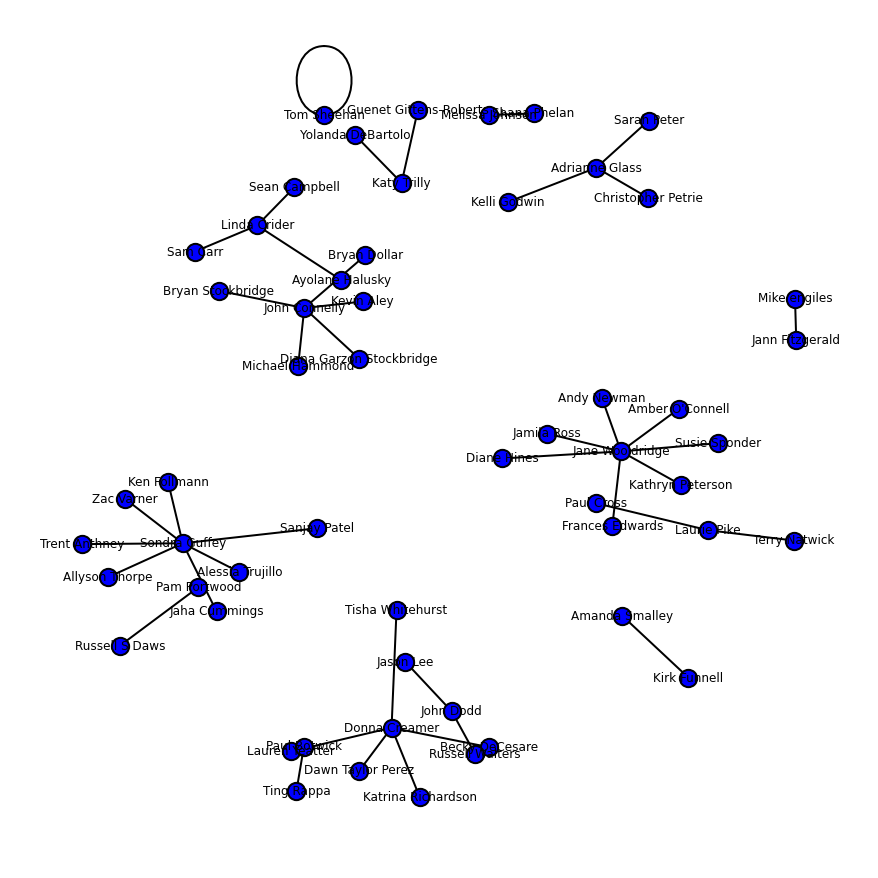

In [ ]:
# Cria o objeto que representa o network map
net = nx.Graph()

# Adiciona os nodos
for item in nodes:
  net.add_node(item)

# Adiciona as conexões
for item in edges:
  net.add_edge(item[0], item[1], length=1000)

# Cria um objeto para configurar a área de plotagem
pos = nx.spring_layout(net, seed=3068, k=0.5, iterations=85) 

# Ajustes de configuração para plotagem
options = {
    "font_size": 12,
    "node_size": 300,
    "node_color": "blue",
    "edgecolors": "black",
    "linewidths": 2,
    "width": 2,
    "with_labels": True
}

# Plota o gráfico
plt.rcParams["figure.figsize"] = [12.00, 12.00]
plt.rcParams["figure.autolayout"] = True
nx.draw(net, pos=pos, **options)
plt.show()

## E agora???

Bom, conseguimos plotar o gráfico. Está longe de ter uma apresentação maravilhosa, mas serve para demonstrar mais um tipo de gráfico que podemos criar com Python! 

## Encerrando

Espero que todos tenham aproveitado este artigo e que tenham aprendido bastante. Vamos deixar aqui alguns links que podem complementar os seus estudos e prepara-los para sua futura profissão!

Alguns destes links estarão escritos na lingua inglesa, mas você pode ativar a tradução automática no seu Google Chrome!!!

- Documentação Oficial
  - [Pandas](https://pandas.pydata.org/docs/)
  - [Seaborn](https://seaborn.pydata.org/)
  - [MatPlotLib](https://matplotlib.org/stable/index.html)
  - [NetworkX](https://networkx.org/documentation/latest/reference/index.html)
- Artigos
  - [Tutorial Seaborn](https://acervolima.com/tutorial-python-seaborn/)
  - [Tutorial MatplotLib](https://www.hashtagtreinamentos.com/saia-do-zero-em-graficos-python?gclid=Cj0KCQjwgO2XBhCaARIsANrW2X0yjydMamgqMk2xZYgPLqN-X3Wyp00DK7f_5AiBnrWYNCJJLHlp8pIaAizLEALw_wcB)
  - [How to use Pandas Power](https://medium.com/@nabiila-29/how-to-use-pandas-power-e58bfa4aa22)
  - [Tutorial NetworkX](https://networkx.org/documentation/latest/tutorial.html)

  